# 3.2.1 Segmentation based on the short-time energy

In [1]:
# Library and audio loading

%matplotlib inline

import librosa
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt

y, sr = librosa.core.load("audio/hylopezus_song.wav")
IPython.display.Audio(data = y, rate = sr)

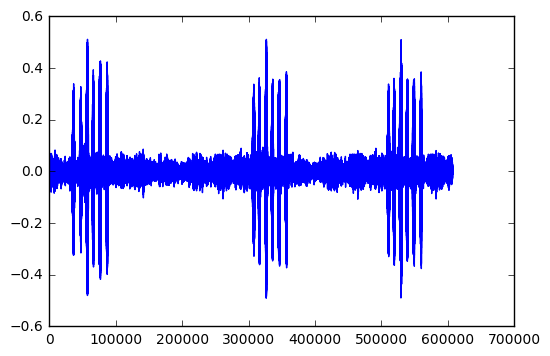

In [2]:
# Audio wave

plt.plot(y)

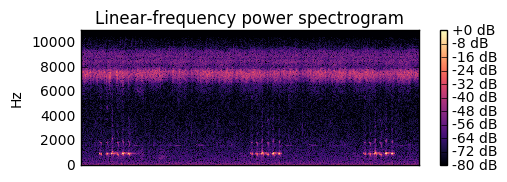

In [3]:
# Spectrogram representation

plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y, n_fft = 2048), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [4]:
# Function to print all frames.

def print_frames(frames):
    n_frames = len(frames[0, :])
    for i in range(n_frames):
        print(frames[:, i])
        
# Returns the energy of a frame in decibel scale.

def energy(frame):
    return np.sum(20*np.log10(np.abs(frame)))

# Returns an array that the i-th position contains the energy
# of frames[i].

def energy_envelope(frames):
    n_frames = len(frames[0, :])
    E = np.zeros(n_frames)
    for i in range(n_frames):
        E[i] = energy(frames[:, i])
    return E

### The audio file is divided into overlapping frames. In this work: frame size is 128 samples corresponding 3ms and adjacent frames overlap 50%.

In [5]:
duration   = librosa.get_duration(y, sr)
frame_size = librosa.time_to_samples(0.003, sr = sr)[0]
hop_size   = int(frame_size * 0.5)
frames     = librosa.util.frame(y, frame_length = frame_size, hop_length = hop_size)

Energy envelope E(m) of the signal x(n) in decibel scale:
\begin{equation}
E(m) = \sum\limits_{i=1}^{N} 20log_{10}|x_m[i]|
\end{equation}
where $x_m[n]$ is m-th frame and $N$ is the total number of samples of frame $x_m$.

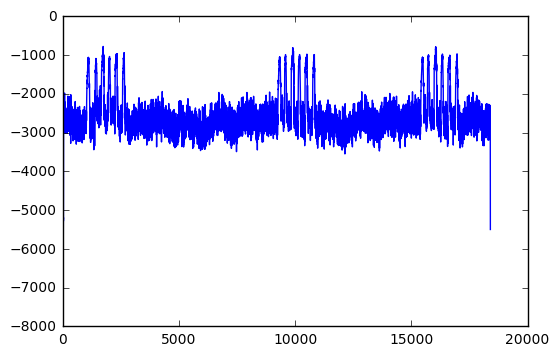

In [6]:
# Energy Envelope by frame
E = energy_envelope(frames)
plt.plot(E)

1) Initial noise level estimate is set equal to the minimum energy of E(m).  
2) Threshold for onset and offset is set to the half of the noise level.  
Flow diagram of syllable search algorithm:  
![alt text](pics/flow.png "Flow diagram of syllable search algorithm")



In [8]:
# Receives energy array. 
# Returns two lists with frame indexes for onsets and offsets.

def syllable_search(E):
    noise_level = np.min(E)
    threshold   = noise_level/2
    n_frames    = len(E)
    
    signal_marker = False

    onset  = []
    offset = []
    
    for i in range(n_frames):
        if E[i] > threshold:
            if not signal_marker:
                onset.append(i)
                signal_marker = True
                E[i] = 0
        else:
            if signal_marker:
                offset.append(i)
                signal_marker = False
                E[i] = 0
            else:
                noise_level = np.mean(E)
                threshold = noise_level/2
    return onset, offset

onset, offset = syllable_search(E)

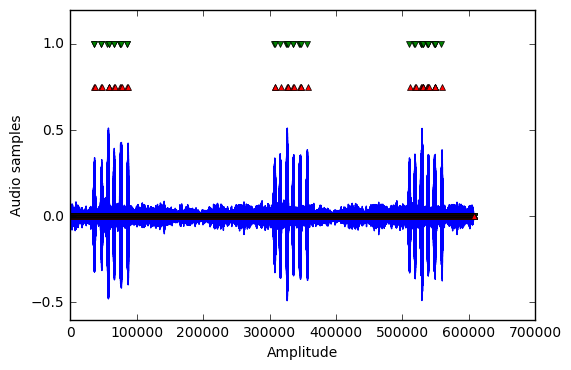

In [9]:
# Receives audio, onset and offset arrays.
# and plots the audio wave with offset/onsets markers
def plot_onsets_offsets(y, onset_s, offset_s):
    onset_s  = librosa.core.frames_to_samples(onset, hop_length = hop_size)
    offset_s = librosa.core.frames_to_samples(offset, hop_length = hop_size)

    onset_plot = np.zeros(len(y))
    onset_plot[onset_s] = 1

    offset_plot = np.zeros(len(y))
    offset_plot[offset_s] = 0.75

    plt.plot(y, 'b', onset_plot, 'gv', offset_plot, 'r^', markersize = 5)
    plt.ylabel("Audio samples")
    plt.xlabel("Amplitude")
    plt.show()

plot_onsets_offsets(y, onset, offset)

In [23]:
onset_s  = librosa.core.frames_to_samples(onset, hop_length = hop_size)
offset_s = librosa.core.frames_to_samples(offset, hop_length = hop_size)
print(offset_s)

IPython.display.Audio(data = y[onset_s[0] - 1000:offset_s[13] + 1000], rate = sr)

[ 35706  37455  46794  48147  58377  58542  58641  65406  67122  74976
  76395  77385  85932  87615 308847 308913 317064 326172 327789 327921
 334950 336831 346071 346830 346995 357390 511731 518232 519882 527769
 530211 530475 530640 530739 537768 537834 537900 539682 548691 548889
 549648 549813 560208]
